## Elimina silencios al inicio y al final, y normaliza el volumen del audio

In [22]:
import os
import librosa
import numpy as np
import soundfile as sf

# ======= CONFIGURACIÓN =======
INPUT_PATH = "Dataset_T"
OUTPUT_PATH = "Dataset_TN"
SAMPLE_RATE = 16000
MIN_RMS_THRESHOLD = 0.01  # Umbral para detectar si el volumen es muy bajo
TARGET_RMS = 0.1          # Nivel deseado si se normaliza
TOP_DB_TRIM = 30          # dB por debajo del pico para recorte de silencio

# ======= FUNCIONES =======

def normalize_if_needed(y, target_rms=0.1, min_rms=0.01):
    """Normaliza RMS solo si el volumen es muy bajo."""
    rms = np.sqrt(np.mean(y**2))
    if rms < min_rms and rms > 0:
        gain = target_rms / rms
        y = y * gain
        y = np.clip(y, -1.0, 1.0)
    return y

def trim_silence(y, top_db=30):
    """Recorta silencio al inicio y final del audio."""
    yt, _ = librosa.effects.trim(y, top_db=top_db)
    return yt

# ======= PROCESAMIENTO =======

os.makedirs(OUTPUT_PATH, exist_ok=True)

for emotion in os.listdir(INPUT_PATH):
    input_emotion_path = os.path.join(INPUT_PATH, emotion)
    output_emotion_path = os.path.join(OUTPUT_PATH, emotion)
    
    if not os.path.isdir(input_emotion_path):
        continue
    
    os.makedirs(output_emotion_path, exist_ok=True)

    for fname in os.listdir(input_emotion_path):
        if fname.lower().endswith('.wav'):
            input_path = os.path.join(input_emotion_path, fname)
            y, sr = librosa.load(input_path, sr=SAMPLE_RATE)
            
            # Recorte de silencios
            y_trimmed = trim_silence(y, top_db=TOP_DB_TRIM)
            
            # Normalización si el volumen es bajo
            y_normalized = normalize_if_needed(y_trimmed, TARGET_RMS, MIN_RMS_THRESHOLD)
            
            # Guardar audio procesado
            output_path = os.path.join(output_emotion_path, fname)
            sf.write(output_path, y_normalized, sr)

print("✅ Procesamiento completado. Audios limpiados y guardados en 'Dataset_TN'.")


C:\Users\curso\AppData\Local\Temp\ipykernel_16560\709786242.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(input_path, sr=SAMPLE_RATE)
C:\Users\curso\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


✅ Procesamiento completado. Audios limpiados y guardados en 'Dataset_TN'.


## Comprime audios para el estudio de análisis de sentimientos

In [24]:
import os
import librosa
import soundfile as sf
import numpy as np

# ========== CONFIGURACIÓN ==========
DATASET_PATH = "Dataset_TN" # Dataset de audios que contiene las carpetas: Alegria, Enojo, Miedo, Neutral, Sorpresa y Tristeza 
OUTPUT_PATH = "Dataset_TNC"
SAMPLE_RATE = 16000
THRESHOLD_DB = -25    # Nivel donde empieza a comprimirse
RATIO = 3.0           # Ratio de compresión
MAKEUP_GAIN = 5.0     # Ganancia final para compensar

# ========== FUNCIONES ==========
def db_to_amp(db):
    return 10 ** (db / 20.0)

def compress_dynamic(y, sr, threshold_db, ratio, makeup_gain_db):
    frame_length = 2048
    hop_length = 512
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_db = librosa.amplitude_to_db(rms, ref=1.0)

    gain_db = np.zeros_like(rms_db)
    for i, db_val in enumerate(rms_db):
        if db_val > threshold_db:
            gain_db[i] = (threshold_db + (db_val - threshold_db) / ratio) - db_val
        else:
            gain_db[i] = 0.0

    gain_db += makeup_gain_db
    gain = db_to_amp(gain_db)

    y_compressed = np.zeros_like(y)
    for i, g in enumerate(gain):
        start = i * hop_length
        end = min(start + frame_length, len(y))
        y_compressed[start:end] += y[start:end] * g

    # Evitar clipping
    max_amp = np.max(np.abs(y_compressed))
    if max_amp > 1.0:
        y_compressed = y_compressed / max_amp

    return y_compressed

# ========== PROCESAR ==========
os.makedirs(OUTPUT_PATH, exist_ok=True)

for emotion_folder in os.listdir(DATASET_PATH):
    input_emotion_path = os.path.join(DATASET_PATH, emotion_folder)
    output_emotion_path = os.path.join(OUTPUT_PATH, emotion_folder)
    os.makedirs(output_emotion_path, exist_ok=True)

    if not os.path.isdir(input_emotion_path):
        continue

    for fname in os.listdir(input_emotion_path):
        if fname.lower().endswith(".wav"):
            path = os.path.join(input_emotion_path, fname)
            y, sr = librosa.load(path, sr=SAMPLE_RATE)
            y_comp = compress_dynamic(y, sr, THRESHOLD_DB, RATIO, MAKEUP_GAIN)
            output_path = os.path.join(output_emotion_path, fname)
            sf.write(output_path, y_comp, sr)

print("Compresión dinámica aplicada a todos los audios.")


Compresión dinámica aplicada a todos los audios.


## Analiza audios y genera el modelo de emociones 

  - Estadísticas para Alegria:
  - Archivos originales: 779
  - Archivos válidos (duración correcta): 203
Porcentaje válidos: 26.1%
  - Necesarios 97 archivos adicionales por data augmentation
  - Estadísticas para Enojo:
  - Archivos originales: 772
  - Archivos válidos (duración correcta): 318
Porcentaje válidos: 41.2%
No se necesitó data augmentation
  - Estadísticas para Miedo:
  - Archivos originales: 766
  - Archivos válidos (duración correcta): 340
Porcentaje válidos: 44.4%
No se necesitó data augmentation
  - Estadísticas para Neutral:
  - Archivos originales: 778
  - Archivos válidos (duración correcta): 298
Porcentaje válidos: 38.3%
  - Necesarios 2 archivos adicionales por data augmentation
  - Estadísticas para Sorpresa:
  - Archivos originales: 772
  - Archivos válidos (duración correcta): 320
Porcentaje válidos: 41.5%
No se necesitó data augmentation
  - Estadísticas para Tristeza:
  - Archivos originales: 781
  - Archivos válidos (duración correcta): 211
Porcentaje válid

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 13, 137, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 13, 137, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 69, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 69, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 69, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 69, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 35, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4, 35, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 35, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 35, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 18, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2, 18, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,275,590 (4.87 MB)

 Trainable params: 1,275,142 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.2121 - loss: 2.8503 - val_accuracy: 0.1667 - val_loss: 1.7876 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3247 - loss: 1.8020 - val_accuracy: 0.1667 - val_loss: 1.8183 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4154 - loss: 1.5003 - val_accuracy: 0.1685 - val_loss: 1.8454 - learning_rate: 1.0000e-04
Epoch 4/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4912 - loss: 1.3864
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4926 - loss: 1.3829 - val_accuracy: 0.1870 - val_loss: 1.8359 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5715 - loss: 1.1829 - val_accuracy: 0.2741 - val_loss: 1.7651 - learning_rate: 5.0000e-05
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6008 - los

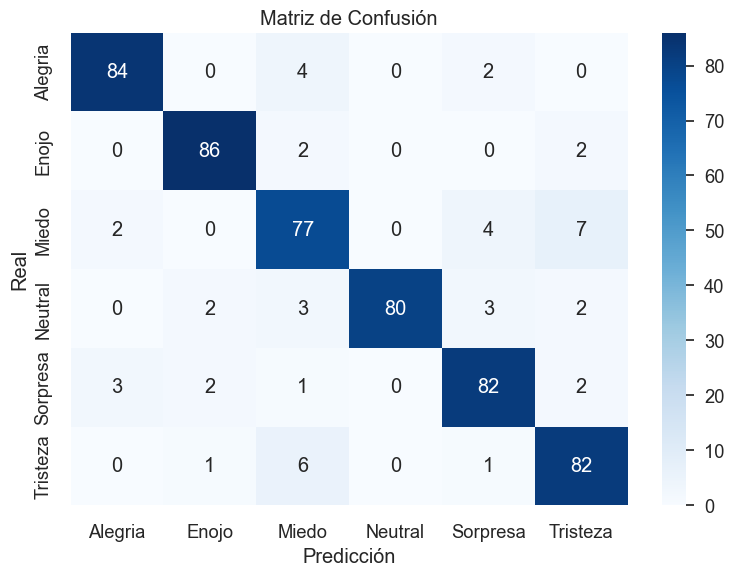

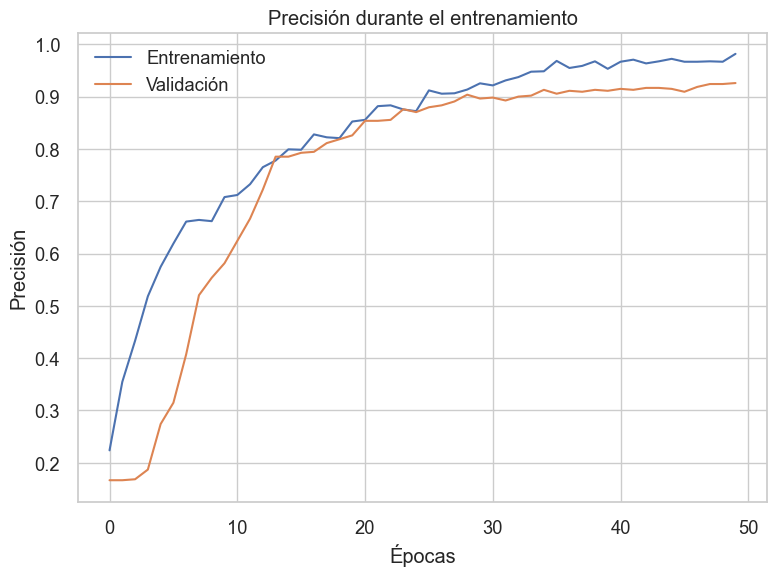

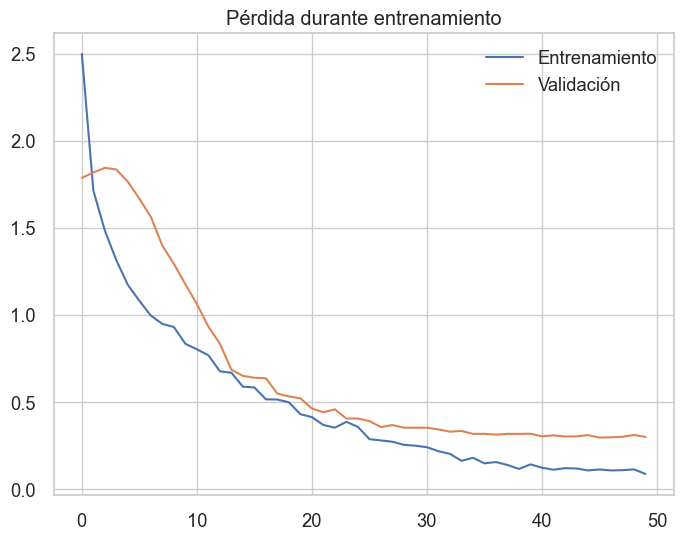

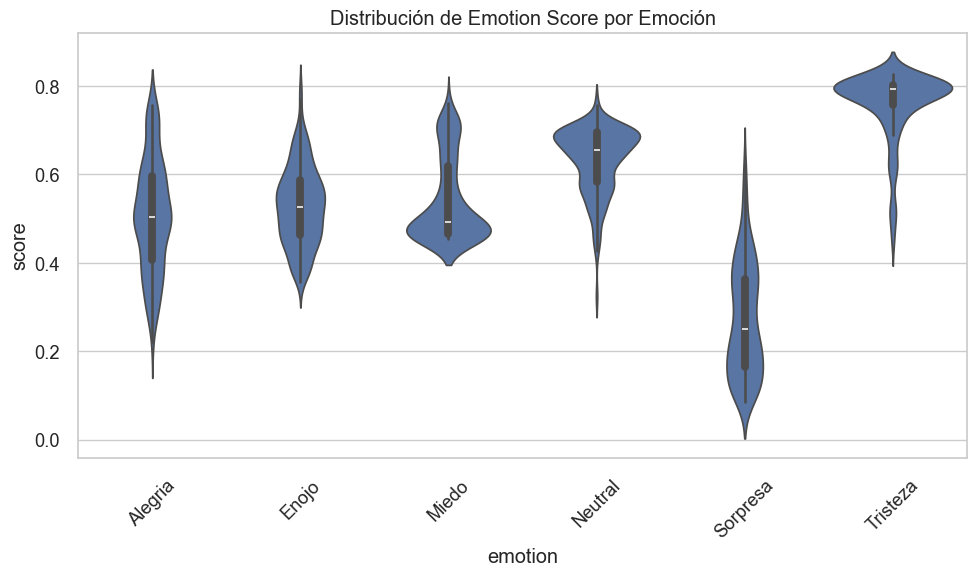

['label_encoder.pkl']

In [39]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.transform import resize
import joblib
from collections import defaultdict
import soundfile as sf
import random

# =================== CONFIG ===================
DATASET_PATH = "Dataset_TNC"
TARGET_SIZE = (13, 100)  # (n_mfcc, frames) - tamaño fijo para los MFCCs
SAMPLE_RATE = 16000
DURATION = 2.2           # Duración fija en segundos
DURATION_MIN = 2.0
DURATION_MAX = 2.3
N_MFCC = 13             # Número de coeficientes MFCC
HOP_LENGTH = 256        # Para calcular fixed_frames
FIXED_FRAMES = int((SAMPLE_RATE * DURATION) / HOP_LENGTH)  # ~138 frames para 2.2s
EMOTIONS = ['Alegria', 'Enojo', 'Miedo', 'Neutral', 'Sorpresa','Tristeza']
MAX_FILES_PER_CLASS = 300
OUTPUT_FILE = "audios_seleccionados.csv"
OUTPUT_AUDIO_DIR = "Dataset_normalizado"

# =================== PARÁMETROS POR EMOCIÓN (PERÚ) ===================
EMOTION_PARAMS_PERU = {
    'Alegria': {
        'target_pitch': (200, 320),      # Más alto que neutral, tono vibrante
        'target_energy': (-11, -3),      # Más energía (peruanos vocalizan fuerte)
        'target_spec_centroid': (2200, 3500),  # Mayor brillantez
        'target_zcr': (0.10, 0.23),
        'target_intonation': (0.8, 1.5),      # Entonación variable y ascendente
        'target_speech_rate': (0.9, 1.3),     # Velocidad moderadamente rápida
        'weight': 1.1
    },
    'Enojo': {
        'target_pitch': (160, 280),      # Menos agudo que el original (evita gritos)
        'target_energy': (-8, -2),       # Más alto que alegría (intensidad)
        'target_spec_centroid': (2500, 4000),  # Máxima aspereza
        'target_zcr': (0.15, 0.27),
        'target_intonation': (0.3, 0.8),      # Entonación plana o descendente brusca
        'target_speech_rate': (0.8, 1.1),     # Velocidad variable, a veces entrecortada
        'weight': 1.1
    },
    'Miedo': {
        'target_pitch': (100, 220),      # Voz más grave e inestable
        'target_energy': (-12, -6),      # Menor energía que enojo
        'target_spec_centroid': (1800, 3000),
        'target_zcr': (0.13, 0.20),      # Corregido rango inválido
        'target_intonation': (0.5, 1.8),      # Entonación muy variable, con picos abruptos
        'target_speech_rate': (0.7, 1.0),     # Velocidad más lenta con pausas
        'weight': 1.0
    },
    'Tristeza': {
        'target_pitch': (80, 150),       # Voz grave y monótona
        'target_energy': (-14, -8),      # No tan bajo como en tu versión
        'target_spec_centroid': (1000, 2000),  # Menos brillo
        'target_zcr': (0.04, 0.09),
        'target_intonation': (0.2, 0.6),      # Entonación muy plana y descendente
        'target_speech_rate': (0.6, 0.9),     # Velocidad lenta
        'weight': 1.0
    },
    'Sorpresa': {
        'target_pitch': (220, 350),      # Pico agudo momentáneo
        'target_energy': (-7, -2),       # Similar a alegría pero más abrupto
        'target_spec_centroid': (2300, 3700),
        'target_zcr': (0.17, 0.28),
        'target_intonation': (1.2, 2.0),      # Entonación muy ascendente
        'target_speech_rate': (1.1, 1.5),     # Velocidad rápida
        'weight': 1.0
    },
    'Neutral': {
        'target_pitch': (120, 200),      # Rango estándar peruano
        'target_energy': (-12, -7),      # Equilibrado
        'target_spec_centroid': (1300, 2100),
        'target_zcr': (0.07, 0.12),
        'target_intonation': (0.7, 1.1),      # Entonación moderada
        'target_speech_rate': (0.9, 1.1),     # Velocidad normal
        'weight': 1.0
    }
}

# Ajustar parámetros para las emociones que estamos usando
EMOTION_PARAMS = {k: v for k, v in EMOTION_PARAMS_PERU.items() if k in EMOTIONS}

# =================== FUNCIONES ===================
def extract_mfcc_features(y, sr=SAMPLE_RATE, n_mfcc=N_MFCC, fixed_frames=FIXED_FRAMES):
    """Extrae características MFCC con tamaño estandarizado"""
    try:
        # Asegurar duración consistente
        y = librosa.util.fix_length(y, size=int(DURATION * sr))
        
        # Extraer MFCCs con parámetros fijos
        mfccs = librosa.feature.mfcc(
            y=y, 
            sr=sr, 
            n_mfcc=n_mfcc,
            n_fft=512,
            hop_length=HOP_LENGTH
        )
        
        # Extraer deltas
        delta = librosa.feature.delta(mfccs)
        delta2 = librosa.feature.delta(mfccs, order=2)
        
        # Ajustar tamaño temporal
        def resize_mfcc(mfcc, target_frames):
            if mfcc.shape[1] < target_frames:
                return np.pad(mfcc, ((0,0), (0, target_frames - mfcc.shape[1])))
            else:
                return mfcc[:, :target_frames]
        
        mfccs = resize_mfcc(mfccs, fixed_frames)
        delta = resize_mfcc(delta, fixed_frames)
        delta2 = resize_mfcc(delta2, fixed_frames)
        
        # Apilar canales (MFCC, delta, delta-delta)
        stacked = np.stack([mfccs, delta, delta2], axis=-1)
        
        # Normalización por instancia
        stacked = (stacked - np.mean(stacked)) / (np.std(stacked) + 1e-6)
        
        return stacked
    except Exception as e:
        print(f"Error procesando MFCC: {e}")
        return None

def augment_audio(y, sr=SAMPLE_RATE, target_duration=DURATION):
    """
    Función mejorada de aumento de datos que:
    1. Selecciona los mejores segmentos del audio basado en energía
    2. Completa la duración requerida con repeticiones inteligentes
    3. Aplica transformaciones de aumento más naturales
    """
    # 1. Encontrar los segmentos más energéticos (mejores partes)
    intervals = librosa.effects.split(y, top_db=20)
    if len(intervals) == 0:
        intervals = np.array([[0, len(y)]])
    
    # Calcular energía de cada segmento
    energies = []
    for start, end in intervals:
        segment = y[start:end]
        energies.append(np.mean(librosa.feature.rms(y=segment)))
    
    # Ordenar segmentos por energía (de mayor a menor)
    sorted_segments = [seg for _, seg in sorted(zip(energies, intervals), reverse=True)]
    
    # 2. Construir nuevo audio con los mejores segmentos
    new_audio = np.array([], dtype=y.dtype)
    remaining_samples = int(target_duration * sr) - len(y)
    
    # Completar con repeticiones inteligentes de los mejores segmentos
    while remaining_samples > 0 and len(sorted_segments) > 0:
        best_start, best_end = sorted_segments[0]
        best_segment = y[best_start:best_end]
        
        # Tomar una porción del mejor segmento (no más de lo necesario)
        take_samples = min(len(best_segment), remaining_samples)
        new_audio = np.concatenate([new_audio, best_segment[:take_samples]])
        remaining_samples -= take_samples
        
        # Rotar segmentos para variedad
        sorted_segments.append(sorted_segments.pop(0))
    
    # Si aún queda espacio, aplicar stretching temporal suave
    if remaining_samples > 0:
        stretch_factor = len(y) / (len(y) + remaining_samples)
        y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)
        new_audio = librosa.util.fix_length(y_stretched, size=int(target_duration * sr))
    else:
        new_audio = librosa.util.fix_length(np.concatenate([y, new_audio]), size=int(target_duration * sr))
    
    # 3. Aplicar transformaciones de aumento más naturales
    transformations = [
        lambda x: x * (1 + np.random.uniform(-0.1, 0.1)),  # Pequeña variación de volumen
        lambda x: x + np.random.normal(0, 0.002, len(x)),  # Ruido muy suave
        lambda x: librosa.effects.pitch_shift(x, sr=sr, n_steps=np.random.uniform(-0.5, 0.5))
    ]
    
    # Aplicar 1-2 transformaciones aleatorias
    for transform in random.sample(transformations, k=np.random.randint(1, 3)):
        new_audio = transform(new_audio)
    
    # Normalizar volumen final
    #new_audio = normalize_volume(new_audio)
    
    return new_audio

def calculate_intonation(pitch_values):
    """Calcula la variabilidad de la entonación basada en el contorno del pitch"""
    if len(pitch_values) < 2:
        return 0
    
    # Filtrar valores extremos (outliers)
    pitch_clean = pitch_values[(pitch_values > np.percentile(pitch_values, 5)) & 
                              (pitch_values < np.percentile(pitch_values, 95))]
    
    if len(pitch_clean) < 2:
        return 0
    
    # Calcular la derivada (cambio en el pitch)
    pitch_diff = np.diff(pitch_clean)
    
    # Calcular la variabilidad absoluta normalizada
    intonation_variability = np.mean(np.abs(pitch_diff)) / np.mean(pitch_clean)
    
    return intonation_variability

def calculate_speech_rate(y, sr=SAMPLE_RATE):
    """Calcula la velocidad del habla basada en la detección de sílabas"""
    # Calcular la envolvente de energía
    rms = librosa.feature.rms(y=y)[0]
    
    # Suavizar la señal RMS
    rms_smooth = np.convolve(rms, np.ones(5)/5, mode='same')
    
    # Encontrar picos (potenciales sílabas)
    peaks, _ = find_peaks(rms_smooth, height=np.mean(rms_smooth)*0.7, distance=5)
    
    # Calcular sílabas por segundo
    duration = len(y) / sr
    speech_rate = len(peaks) / duration if duration > 0 else 0
    
    return speech_rate
    
def calculate_score(audio_features, emotion):
    """Calcula el score basado en qué tan cerca están las características de los rangos objetivo"""
    params = EMOTION_PARAMS[emotion]
    score = 0
    
    # Pitch score (dentro del rango objetivo)
    pitch = audio_features['pitch']
    target_pitch_min, target_pitch_max = params['target_pitch']
    if target_pitch_min <= pitch <= target_pitch_max:
        pitch_score = 1.0
    else:
        # Penalización por estar fuera del rango
        distance = min(abs(pitch - target_pitch_min), abs(pitch - target_pitch_max))
        pitch_score = np.clip(1 - (distance / 100), 0, 1)  # Normalizar la distancia
    
    # Energy score (RMS en dB)
    energy_db = 10 * np.log10(audio_features['rms'] + 1e-6)  # Convertir a dB
    target_energy_min, target_energy_max = params['target_energy']
    if target_energy_min <= energy_db <= target_energy_max:
        energy_score = 1.0
    else:
        distance = min(abs(energy_db - target_energy_min), abs(energy_db - target_energy_max))
        energy_score = np.clip(1 - (distance / 5), 0, 1)  # Normalizar la distancia
    
    # Spectral Centroid score
    centroid = audio_features['centroid']
    target_centroid_min, target_centroid_max = params['target_spec_centroid']
    if target_centroid_min <= centroid <= target_centroid_max:
        centroid_score = 1.0
    else:
        distance = min(abs(centroid - target_centroid_min), abs(centroid - target_centroid_max))
        centroid_score = np.clip(1 - (distance / 500), 0 ,1)  # Normalizar la distancia
    
    # ZCR score
    zcr = audio_features['zcr']
    target_zcr_min, target_zcr_max = params['target_zcr']
    if target_zcr_min <= zcr <= target_zcr_max:
        zcr_score = 1.0
    else:
        distance = min(abs(zcr - target_zcr_min), abs(zcr - target_zcr_max))
        zcr_score = np.clip(1 - (distance / 0.05), 0 ,1)  # Normalizar la distancia
    
    # Intonation score
    intonation = audio_features['intonation']
    target_intonation_min, target_intonation_max = params['target_intonation']
    if target_intonation_min <= intonation <= target_intonation_max:
        intonation_score = 1.0
    else:
        distance = min(abs(intonation - target_intonation_min), abs(intonation - target_intonation_max))
        intonation_score = np.clip(1 - (distance / 0.5), 0, 1)
    
    # Speech rate score
    speech_rate = audio_features['speech_rate']
    target_speech_rate_min, target_speech_rate_max = params['target_speech_rate']
    if target_speech_rate_min <= speech_rate <= target_speech_rate_max:
        speech_rate_score = 1.0
    else:
        distance = min(abs(speech_rate - target_speech_rate_min), abs(speech_rate - target_speech_rate_max))
        speech_rate_score = np.clip(1 - (distance / 0.3), 0, 1)
    
    # Score ponderado con las nuevas características
    total_score = (pitch_score * 0.25 + energy_score * 0.20 + 
                  centroid_score * 0.15 + zcr_score * 0.10 +
                  intonation_score * 0.15 + speech_rate_score * 0.15) * params['weight']
    
    return total_score    

# =================== CARGA Y PROCESAMIENTO ===================
X, y = [], []
selected_info = []
count_per_class = defaultdict(int)
before_count = {}       # Archivos originales en cada carpeta
valid_count = {}        # Archivos válidos después de filtrar por duración
after_count = {}        # Archivos después de data augmentation
os.makedirs(OUTPUT_AUDIO_DIR, exist_ok=True)

for emotion in EMOTIONS:
    folder = os.path.join(DATASET_PATH, emotion)
    if not os.path.isdir(folder):
        continue
    
    # Contar archivos originales
    files = sorted(os.listdir(folder))
    before_count[emotion] = len([f for f in files if f.lower().endswith('.wav')])
    valid_count[emotion] = 0
    scored_files = []

    for fname in files:
        if fname.lower().endswith(".wav"):
            file_path = os.path.join(folder, fname.strip())
            y_temp, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            intervals = librosa.effects.split(y_temp, top_db=20)
            y_temp = np.concatenate([y_temp[start:end] for start, end in intervals])

            duration = librosa.get_duration(y=y_temp, sr=sr)
            if duration < DURATION_MIN or duration > DURATION_MAX:
                continue

            valid_count[emotion] += 1  # Contar archivos válidos

            y_temp = librosa.util.fix_length(y_temp, size=int(round(DURATION,1) * sr))

            pitch = librosa.yin(y_temp, fmin=50, fmax=400, sr=sr)
            pitch = pitch[pitch > 0]
            pitch_mean = np.mean(pitch) if len(pitch) > 0 else 0
            
            rms = np.mean(librosa.feature.rms(y=y_temp))
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_temp))
            centroid = np.mean(librosa.feature.spectral_centroid(y=y_temp, sr=sr))
            # Calcular nuevas características
            intonation = calculate_intonation(pitch)
            speech_rate = calculate_speech_rate(y_temp, sr)

            audio_features = {
                'pitch': pitch_mean,
                'rms': rms,
                'zcr': zcr,
                'centroid': centroid,
                'intonation': intonation,
                'speech_rate': speech_rate
            }
            
            score = calculate_score(audio_features, emotion)
            
            scored_files.append({
                'score': score,
                'pitch': pitch_mean,
                'rms': rms,
                'zcr': zcr,
                'centroid': centroid,
                'intonation': intonation,
                'speech_rate': speech_rate,
                'file_path': file_path,
                'fname': fname.strip(),
                'emotion': emotion,
                'audio_data': y_temp
            })

    # Estadísticas antes de data augmentation
    print(f"  - Estadísticas para {emotion}:")
    print(f"  - Archivos originales: {before_count[emotion]}")
    print(f"  - Archivos válidos (duración correcta): {valid_count[emotion]}")
    if valid_count[emotion] > 0:
        print(f"Porcentaje válidos: {valid_count[emotion]/before_count[emotion]*100:.1f}%")
    else:
        print("No hay archivos válidos para esta emoción")

    top_files = sorted(scored_files, key=lambda x: -x['score'])[:MAX_FILES_PER_CLASS]

    # Agregar data augmentation si hay menos de MAX_FILES_PER_CLASS
    needed = MAX_FILES_PER_CLASS - len(top_files)
    if needed > 0 and len(top_files) > 0:
        print(f"  - Necesarios {needed} archivos adicionales por data augmentation")
        
        for i in range(needed):
            original = top_files[i % len(top_files)]
            augmented_y = augment_audio(original['audio_data'])
            aug_name = f"aug_{i}_{original['fname']}"
            top_files.append({**original, 'fname': aug_name, 'audio_data': augmented_y})
            
    else:
        print("No se necesitó data augmentation")

    after_count[emotion] = len(top_files)

    for item in top_files[:MAX_FILES_PER_CLASS]:
        mfcc_features = extract_mfcc_features(item['audio_data'])
        if mfcc_features is not None:
            X.append(mfcc_features)
            y.append(emotion)
            item['ruta'] = item['file_path']
            selected_info.append(item)
            count_per_class[emotion] += 1

            emotion_dir = os.path.join(OUTPUT_AUDIO_DIR, emotion)
            os.makedirs(emotion_dir, exist_ok=True)
            save_path = os.path.join(emotion_dir, item['fname'])
            sf.write(save_path, item['audio_data'], samplerate=SAMPLE_RATE)

selected_df = pd.DataFrame(selected_info)
selected_df.to_csv(OUTPUT_FILE, index=False)

# Mostrar estadística de conteo antes y después
print("Resumen estadístico de audios por emoción:")
print(f"{'Emoción':<12} | {'Originales':^9} | {'Válidos':^7} | {'Final':^5}")
print("-" * 45)
for emotion in EMOTIONS:
    print(f"{emotion:<12} | {before_count.get(emotion, 0):^9} | {valid_count.get(emotion, 0):^7} | {after_count.get(emotion, 0):^5}")

# Calcular porcentaje de uso de archivos válidos
print("Porcentaje de archivos válidos utilizados:")
for emotion in EMOTIONS:
    valid = valid_count.get(emotion, 0)
    final = after_count.get(emotion, 0)
    if valid > 0:
        used = min(valid, MAX_FILES_PER_CLASS)
        pct_used = used / valid * 100
        augmented = max(0, final - valid)
        print(f"{emotion:<12}: {used}/{valid} ({pct_used:.1f}% usado) + {augmented} aumentados")
    else:
        print(f"{emotion:<12}: No hay archivos válidos")

# =================== MODELO CNN PARA MFCCs ===================
X = np.array(X)
y = np.array(y)

# Verificar las dimensiones reales de los datos
print(f"Forma de los datos de entrada: {X.shape}")  # Debería ser (n_samples, 13, frames, 3)

# Encoding de etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Distribución de clases:", dict(zip(le.classes_, np.bincount(y_encoded))))

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Pesos de clase
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))

# Aplicar los pesos adicionales de EMOTION_PARAMS
for emotion, weight in EMOTION_PARAMS.items():
    if emotion in le.classes_:
        idx = np.where(le.classes_ == emotion)[0][0]
        if idx in class_weights:
            class_weights[idx] *= weight['weight']

# Arquitectura del modelo adaptada para MFCCs
input_shape = X_train.shape[1:]  # Usamos las dimensiones reales de los datos

# Después de generar todos los MFCCs (antes del entrenamiento)
shapes = [x.shape for x in X]
unique_shapes = set(shapes)

if len(unique_shapes) == 1:
    print(f"Todos los espectrogramas tienen la misma forma: {unique_shapes.pop()}")
else:
    print("Existe variación en las dimensiones:")
    for shape in unique_shapes:
        count = shapes.count(shape)
        print(f"- Forma {shape}: {count} muestras")
        
model = models.Sequential([
    layers.Input(shape=input_shape),
    
    # Primera capa convolucional - extrae patrones frecuenciales
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.1),
    
    # Segunda capa convolucional - extrae patrones más complejos
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.1),
    
    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.2),
    
    # Aplanar para capas densas
    layers.Flatten(),
    
    # Capa densa con tamaño ajustado dinámicamente
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    # Capa de salida
    layers.Dense(len(EMOTIONS), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
ModelCheckpoint = ModelCheckpoint('best_model_emotions.keras', save_best_only=True),

model.summary()

# Entrenamiento sin early_stop
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, ModelCheckpoint],
    verbose=1
)

# =================== EVALUACIÓN ===================
y_pred = model.predict(X_test).argmax(axis=1)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# =================== Matriz de Confusión ===================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig("matriz_confusion.png")
plt.show()

# =============Gráfico de precisión=========================
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label="Entrenamiento")
plt.plot(history.history['val_accuracy'], label="Validación")
plt.title("Precisión durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.tight_layout()
plt.savefig("precision_entrenamiento.png")
plt.show()

#=============Pérdida durante el entrenamiento==============
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.show()

# =================== VIOLIN PLOT ===================
plt.figure(figsize=(10,6))
sns.violinplot(data=selected_df, x='emotion', y='score')
plt.title("Distribución de Emotion Score por Emoción")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Guardado del modelo
#model.save("modelo_emociones_mfcc_cnn.h5")
joblib.dump(le, "label_encoder.pkl")

## Visualización de datos y parámetros

### 1. Instalación de dependencias

In [14]:
#!pip install librosa pandas matplotlib seaborn scikit-learn xgboost tensorflow tqdm ipywidgets
#!pip install ipython

### 2. Configuración inicial

In [28]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from ipywidgets import interact, Dropdown
import IPython.display as ipd

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option('display.max_columns', 50)

### 3. Función para extraer características con análisis por emoción

In [30]:
def extract_emotion_features(file_path, sr=22050, duration=4):
    """Extrae características acústicas con énfasis en patrones emocionales"""
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, max(0, sr * duration - len(audio))), 'constant')
        
        features = {}
        
        # 1. Características básicas por emoción
        features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y=audio))
        features['rms'] = np.mean(librosa.feature.rms(y=audio))
        
        # 2. Análisis espectral por bandas emocionales
        freqs = librosa.fft_frequencies(sr=sr)
        spectrum = np.abs(librosa.stft(audio))
        
        # Bandas emocionales clave
        emotion_bands = {
            'bass': (60, 250),       # Tristeza
            'low_mid': (250, 500),   # Neutral
            'mid': (500, 2000),      # Alegría
            'upper_mid': (2000, 4000), # Enojo
            'high': (4000, 8000)     # Miedo/Sorpresa
        }
        
        for band, (low, high) in emotion_bands.items():
            band_mask = (freqs >= low) & (freqs < high)
            features[f'{band}_energy'] = np.log1p(np.sum(spectrum[band_mask, :]))
        
        # 3. Características específicas por emoción
        pitch = librosa.yin(audio, fmin=50, fmax=500, sr=sr)
        pitch = pitch[pitch > 0]  # Filtrar valores inválidos
        
        features.update({
            'pitch_mean': np.mean(pitch) if len(pitch) > 0 else 0,
            'pitch_std': np.std(pitch) if len(pitch) > 0 else 0,
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr)),
            'harmonic_ratio': np.mean(librosa.effects.harmonic(y=audio))
        })
        
        # 4. MFCCs (primeros 13 coeficientes)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        for i in range(mfccs.shape[0]):
            features[f'mfcc_{i}'] = np.mean(mfccs[i])
        
        return features
    
    except Exception as e:
        print(f"Error procesando {file_path}: {str(e)}")
        return None


### 4. Cargar dataset y extraer características

In [32]:
def load_audio_dataset(base_path, emotions):
    """Carga el dataset y extrae características emocionales"""
    data = []
    
    for emotion in emotions:
        emotion_path = os.path.join(base_path, emotion)
        if not os.path.exists(emotion_path):
            print(f"¡Carpeta no encontrada! {emotion_path}")
            continue
            
        print(f"Procesando: {emotion}")
        files = [f for f in os.listdir(emotion_path) if f.endswith(('.wav', '.mp3'))]
        
        for file in files[:100]:  # Limitar a 100 archivos por emoción para demo
            file_path = os.path.join(emotion_path, file)
            features = extract_emotion_features(file_path)
            if features:
                features['emotion'] = emotion
                data.append(features)
    
    return pd.DataFrame(data)

# %%
# Ejecutar para cargar datos (ajusta la ruta)
DATASET_PATH = "Dataset_TNC"
EMOTIONS = ['Alegria', 'Enojo', 'Miedo', 'Neutral', 'Sorpresa', 'Tristeza']

df = load_audio_dataset(DATASET_PATH, EMOTIONS)

# Mostrar primeras filas
df.head()

Procesando: Alegria
Procesando: Enojo
Procesando: Miedo
Procesando: Neutral
Procesando: Sorpresa
Procesando: Tristeza


,zcr,rms,bass_energy,low_mid_energy,mid_energy,upper_mid_energy,high_energy,pitch_mean,pitch_std,spectral_centroid,harmonic_ratio,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,emotion
0,0.026559,0.085331,10.263640,9.402754,9.820734,9.314598,9.293533,315.260438,190.066718,706.421280,-0.000010,-355.065857,64.178696,-6.937340,20.042164,4.611584,11.914010,-2.629664,9.477399,-4.340281,5.966325,-5.759192,-4.656771,-0.429317,Alegria
1,0.032641,0.095219,10.374102,9.363688,10.302294,9.410157,9.852281,318.892818,187.220973,876.154035,0.000010,-341.075775,60.740280,-5.091700,21.410496,-3.844184,15.561652,-8.014669,9.453014,-3.980250,8.186721,-4.531145,-4.476864,0.587383,Alegria
2,0.044213,0.097811,9.773499,10.160285,10.417094,9.542622,9.462138,305.871083,156.898602,857.574037,-0.000003,-346.492554,84.716377,-6.609622,22.906784,-0.447011,9.311101,-8.605622,8.356414,-12.449963,-2.623058,-1.909032,-15.834416,-8.216291,Alegria
3,0.054095,0.068827,9.351527,10.066652,10.205116,8.690559,8.131374,182.864994,85.951674,974.829454,-0.000006,-311.906738,165.327469,-6.984505,14.042977,2.512044,5.539312,-9.661669,-8.175103,-13.546440,-7.898137,-9.420876,-8.683855,-4.262492,Alegria
4,0.066341,0.081239,9.325089,10.151820,10.573640,8.819156,8.671868,226.918900,123.987342,1065.938424,-0.000005,-295.114380,146.971634,-9.160359,3.750719,-5.245017,8.056056,-9.750878,-9.557497,-18.845987,-3.297694,-1.967134,-6.053465,-1.792178,Alegria


### 5. Visualización interactiva por emoción

In [34]:
def plot_emotion_features(emotion):
    """Visualiza características para una emoción específica"""
    plt.figure(figsize=(15, 8))
    
    # Filtrar datos
    subset = df[df['emotion'] == emotion]
    
    # 1. Gráfico de características principales
    plt.subplot(2, 2, 1)
    features_to_plot = ['zcr', 'rms', 'pitch_mean', 'spectral_centroid']
    sns.barplot(data=subset[features_to_plot].mean().to_frame().T)
    plt.title(f'Características principales - {emotion}')
    plt.xticks(rotation=45)
    
    # 2. Energía por bandas
    plt.subplot(2, 2, 2)
    band_cols = [col for col in df.columns if '_energy' in col]
    sns.barplot(data=subset[band_cols].mean().to_frame().T)
    plt.title(f'Energía en bandas - {emotion}')
    plt.xticks(rotation=45)
    
    # 3. Distribución de pitch
    plt.subplot(2, 2, 3)
    sns.histplot(subset['pitch_mean'], bins=20, kde=True)
    plt.title(f'Distribución de pitch - {emotion}')
    plt.xlabel('Frecuencia (Hz)')
    
    # 4. MFCCs característicos
    plt.subplot(2, 2, 4)
    mfcc_cols = [f'mfcc_{i}' for i in range(5)]  # Primeros 5 MFCCs
    sns.heatmap(subset[mfcc_cols].mean().to_frame().T, annot=True, cmap='coolwarm')
    plt.title(f'MFCCs clave - {emotion}')
    
    plt.tight_layout()
    plt.show()
    
    # Reproducir un audio de ejemplo
    example_file = os.path.join(DATASET_PATH, emotion, os.listdir(os.path.join(DATASET_PATH, emotion))[0])
    print(f"\nAudio de ejemplo ({emotion}):")
    return ipd.Audio(example_file)

# %%
# Selector interactivo de emociones
emotion_selector = Dropdown(options=EMOTIONS, description='Emoción:')
interact(plot_emotion_features, emotion=emotion_selector)


interactive(children=(Dropdown(description='Emoción:', options=('Alegria', 'Enojo', 'Miedo', 'Neutral', 'Sorpr…

<function __main__.plot_emotion_features(emotion)>

### 6. Análisis comparativo entre emociones

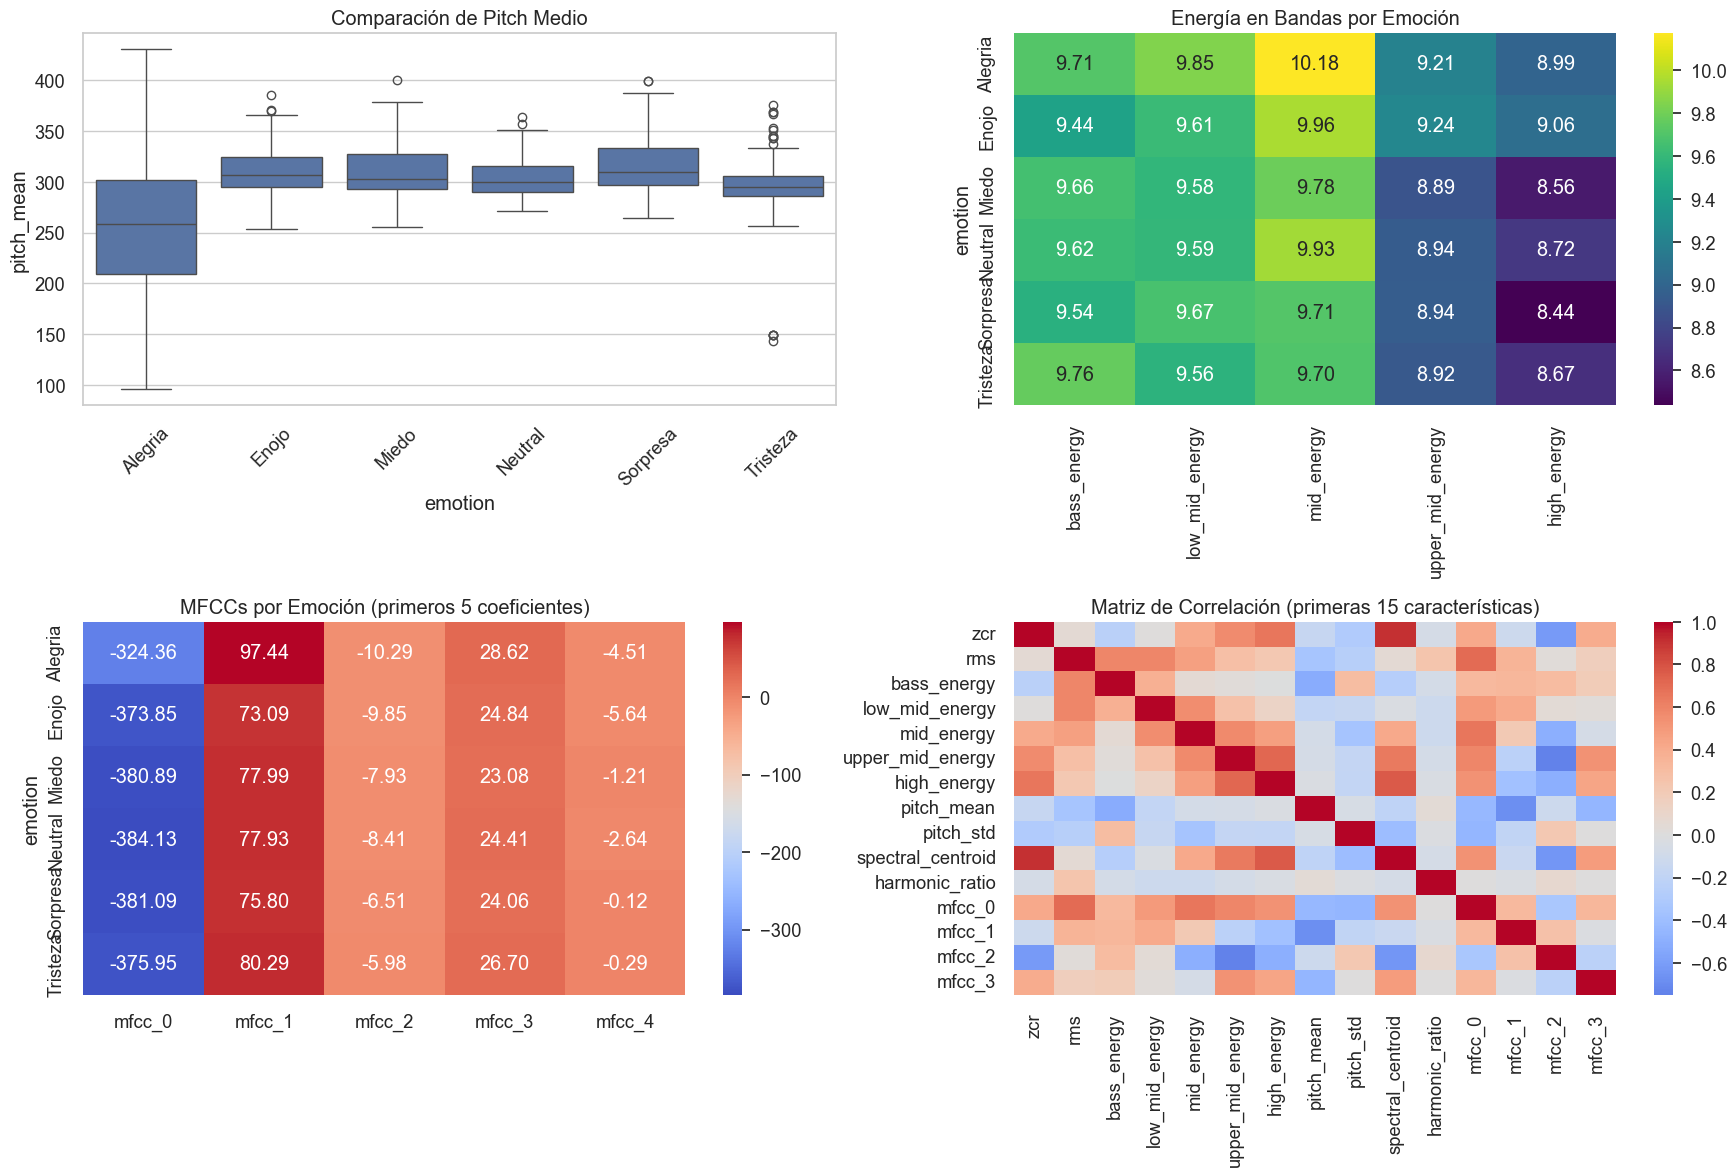

In [36]:
def plot_emotion_comparison():
    """Compara características clave entre todas las emociones"""
    plt.figure(figsize=(18, 12))
    
    # 1. Comparación de pitch
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df, x='emotion', y='pitch_mean', order=EMOTIONS)
    plt.title('Comparación de Pitch Medio')
    plt.xticks(rotation=45)
    
    # 2. Comparación de energía en bandas
    plt.subplot(2, 2, 2)
    band_cols = [col for col in df.columns if '_energy' in col]
    band_means = df.groupby('emotion')[band_cols].mean()
    sns.heatmap(band_means, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Energía en Bandas por Emoción')
    
    # 3. Comparación de MFCCs
    plt.subplot(2, 2, 3)
    mfcc_cols = [f'mfcc_{i}' for i in range(5)]
    mfcc_means = df.groupby('emotion')[mfcc_cols].mean()
    sns.heatmap(mfcc_means, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('MFCCs por Emoción (primeros 5 coeficientes)')
    
    # 4. Correlación entre características
    plt.subplot(2, 2, 4)
    corr_matrix = df.select_dtypes(include=np.number).corr()
    sns.heatmap(corr_matrix.iloc[:15, :15], cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación (primeras 15 características)')
    
    plt.tight_layout()
    plt.show()

# %%
plot_emotion_comparison()

In [16]:
#!pip install librosa matplotlib numpy tk

## Visualizar un espectograma de 1 audio de Enojo

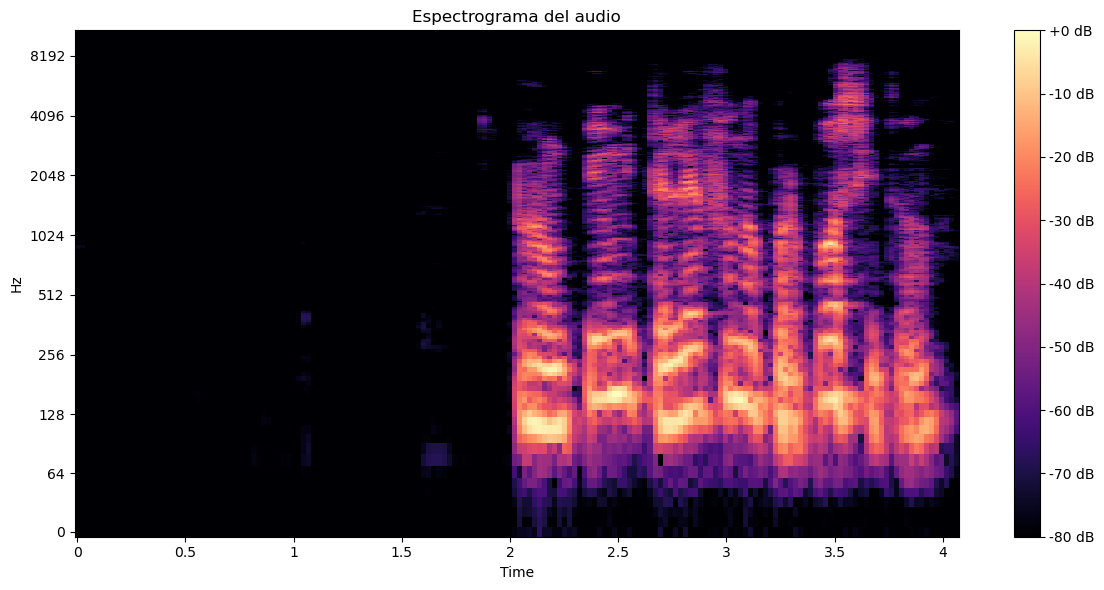

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def mostrar_espectrograma(ruta_audio):
    y, sr = librosa.load(ruta_audio)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma del audio')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
mostrar_espectrograma("Dataset/Enojo/Enojo_001.wav")

## Visualizar un espectograma de Alegría

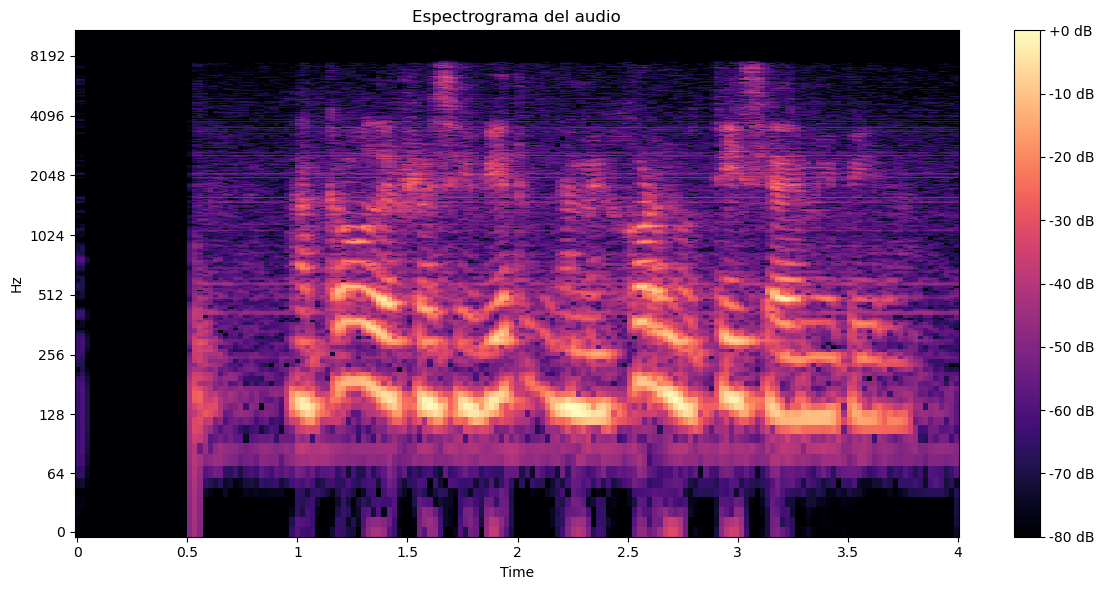

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def mostrar_espectrograma(ruta_audio):
    y, sr = librosa.load(ruta_audio)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma del audio')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
mostrar_espectrograma("Dataset_comprimido/Alegria/alegria (1) - Miguel Azaña Flores.wav")

## Tristeza

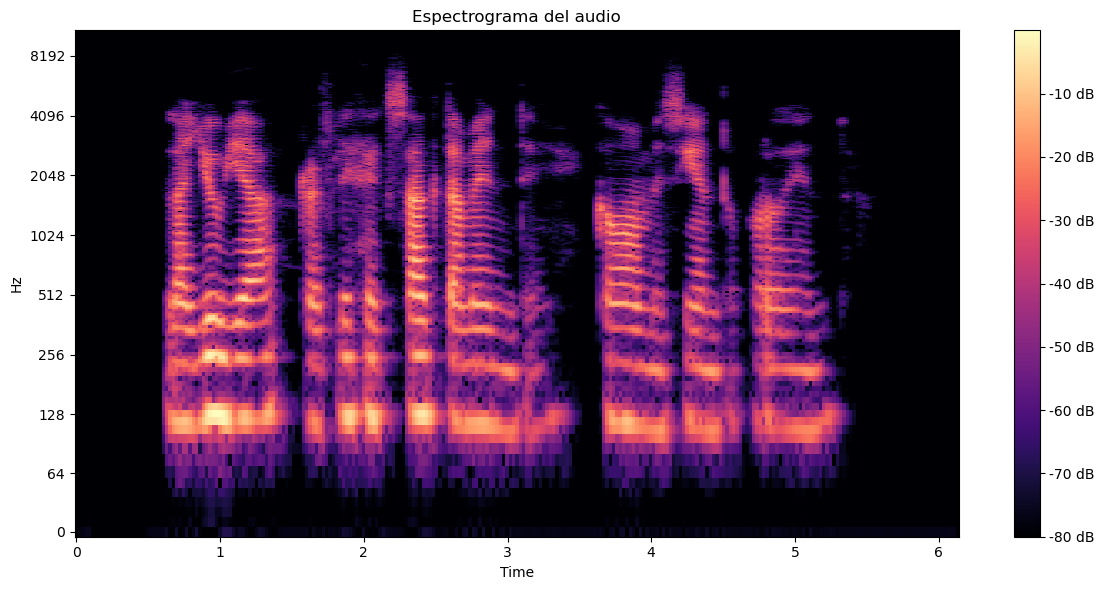

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def mostrar_espectrograma(ruta_audio):
    y, sr = librosa.load(ruta_audio)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma del audio')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
mostrar_espectrograma("Dataset/Tristeza/tristeza_029.wav")

## Para visualizar la compresión de un solo audio


🔊 Reproduciendo audio ORIGINAL:



🔇 Reproduciendo audio COMPRIMIDO:



📊 Comparación visual:


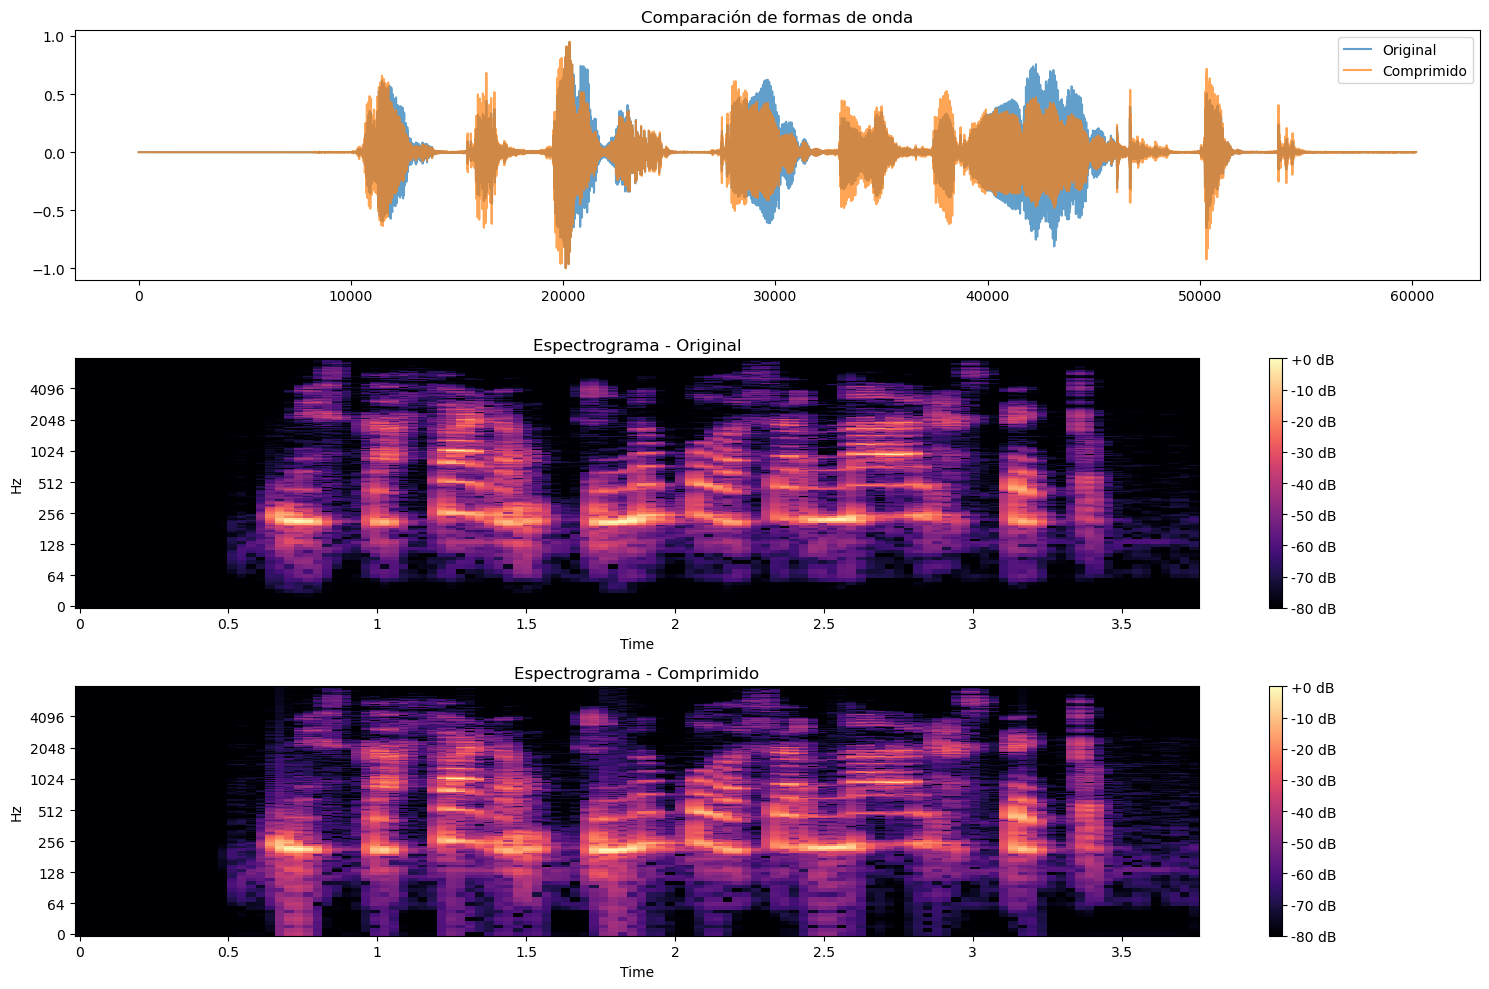


💾 Audio comprimido guardado en: Dataset/Enojo/Enojo_201_compressed.wav


In [5]:
import os
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog, Tk
from IPython.display import Audio, display

# ========== CONFIGURACIÓN ==========
SAMPLE_RATE = 16000
THRESHOLD_DB = -25    # Nivel donde empieza a comprimirse
RATIO = 3.0           # Ratio de compresión
MAKEUP_GAIN = 5.0     # Ganancia final para compensar

# ========== FUNCIONES ==========
def db_to_amp(db):
    return 10 ** (db / 20.0)

def compress_dynamic(y, sr, threshold_db, ratio, makeup_gain_db):
    frame_length = 2048
    hop_length = 512
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_db = librosa.amplitude_to_db(rms, ref=1.0)

    gain_db = np.zeros_like(rms_db)
    for i, db_val in enumerate(rms_db):
        if db_val > threshold_db:
            gain_db[i] = (threshold_db + (db_val - threshold_db) / ratio) - db_val
        else:
            gain_db[i] = 0.0

    gain_db += makeup_gain_db
    gain = db_to_amp(gain_db)

    y_compressed = np.zeros_like(y)
    for i, g in enumerate(gain):
        start = i * hop_length
        end = min(start + frame_length, len(y))
        y_compressed[start:end] += y[start:end] * g

    # Evitar clipping
    max_amp = np.max(np.abs(y_compressed))
    if max_amp > 1.0:
        y_compressed = y_compressed / max_amp

    return y_compressed

def plot_comparison(y_orig, y_comp, sr):
    plt.figure(figsize=(15, 10))
    
    # Onda de audio
    plt.subplot(3, 1, 1)
    plt.plot(y_orig, alpha=0.7, label='Original')
    plt.plot(y_comp, alpha=0.7, label='Comprimido')
    plt.title('Comparación de formas de onda')
    plt.legend()
    
    # Espectrograma original
    plt.subplot(3, 1, 2)
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
    librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma - Original')
    
    # Espectrograma comprimido
    plt.subplot(3, 1, 3)
    D_comp = librosa.amplitude_to_db(np.abs(librosa.stft(y_comp)), ref=np.max)
    librosa.display.specshow(D_comp, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma - Comprimido')
    
    plt.tight_layout()
    plt.show()

def process_single_file():
    # Configurar interfaz para seleccionar archivo
    root = Tk()
    root.withdraw()
    file_path = "Dataset/Enojo/Enojo_201.wav"
    
    if not file_path:
        print("No se seleccionó ningún archivo.")
        return
    
    # Cargar audio original
    y_orig, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Mostrar audio original
    print("\n🔊 Reproduciendo audio ORIGINAL:")
    display(Audio(data=y_orig, rate=sr))
    
    # Aplicar compresión
    y_comp = compress_dynamic(y_orig, sr, THRESHOLD_DB, RATIO, MAKEUP_GAIN)
    
    # Mostrar audio comprimido
    print("\n🔇 Reproduciendo audio COMPRIMIDO:")
    display(Audio(data=y_comp, rate=sr))
    
    # Mostrar comparación visual
    print("\n📊 Comparación visual:")
    plot_comparison(y_orig, y_comp, sr)
    
    # Guardar archivo comprimido (opcional)
    output_path = os.path.splitext(file_path)[0] + "_compressed.wav"
    sf.write(output_path, y_comp, sr)
    print(f"\n💾 Audio comprimido guardado en: {output_path}")

# ========== EJECUCIÓN ==========
if __name__ == "__main__":
    process_single_file()